# Projeto 1 - Base de Dados Covid

O objetivo do projeto será desenvolver um estudo no dataset COVID.csv , base esta que contém informações sobre casos de COVID. Ou seja a partir do diagnóstico de sintomas e informações dos pacientes deve-se
desenvolver um modelo para prever casos confirmados de COVID'.

Membros do grupo:
- Ana Luzia Akiyama
- Fernanda Kawasaki
- Henrique Castro
- Liosvaldo Santiago
- Maria Julia Martins
- Wandemberg Gibaut

Este arquivo contém testes relativos ao uso do modelo de classificação Naive Bayes. Para manter este notebook mais enxuto, o processo de EDA foi removido (mas pode ser encontrado no notebook principal)

In [5]:
!pip install -U scikit-learn

You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import eda
pd.set_option("display.max_columns", None)

In [9]:
df = pd.read_csv('covid.csv')

In [10]:
df = eda.pre_process(df)
df = eda.categorical_process(df)
df = eda.imputing_nan(df)
df = eda.feature_engineering(df)
# df = eda.full_processing(df)

# Modelagem
Para avaliar desempenho de nosso modelo nos vamos utilizar a metrica de **ROC AUC** e  **recall**. A métrica ROC AUC foi escolhida para podermos comparar os difrentes modelos desenvolvidos. Já a métrica de recall foiescolhida  porque no caso de doencas infecciosas queremos minimizar os falsos negativos, ja que caso alguem infectado receba um teste negativo ela continuara espalhando a doenca. Pode-se argumentar que os falsos positivos causariam gastos com tratamento e prevencao da doenca, mas no caso do COVID esses gastos sao relativamente baixos, uma vez que um paciente que testou positivo pode ser encaminhado para quarentena em casa.

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import GaussianNB

## Remoção de dados indisponíveis

É importante notar que alguns dados no dataset não estarão presentes no momento da análise. Exemplos disso são as colunas icu e intubed, que são dependem de um diagnóstico positivo de COVID-19. Assim, não teríamos esses dados no ambiente de produção. Logo, essas colunas serão removidas para realizar o treinamento dos modelos.

In [12]:
# Drop de colunas que nao serao usadas ou que nao estarao disponiveis
X = df.drop(columns=['covid_res', 'id', 'entry_date', 'date_symptoms', 'date_died', 'intubed', 'icu']) 
y = df['covid_res']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499692 entries, 0 to 499691
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sex                  499692 non-null  int64  
 1   patient_type         499692 non-null  int64  
 2   pneumonia            499692 non-null  float64
 3   age                  499692 non-null  int64  
 4   pregnancy            499692 non-null  int64  
 5   diabetes             499692 non-null  int64  
 6   copd                 499692 non-null  int64  
 7   asthma               499692 non-null  int64  
 8   inmsupr              499692 non-null  int64  
 9   hypertension         499692 non-null  int64  
 10  other_disease        499692 non-null  int64  
 11  cardiovascular       499692 non-null  int64  
 12  obesity              499692 non-null  int64  
 13  renal_chronic        499692 non-null  int64  
 14  tobacco              499692 non-null  int64  
 15  contact_other_cov

## Naive Bayes
best performance -> ROC 0.5825261549475066

In [49]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     83711
           1       0.69      0.26      0.37     66197

    accuracy                           0.62    149908
   macro avg       0.65      0.58      0.55    149908
weighted avg       0.64      0.62      0.57    149908



In [15]:
roc_auc_score(y_test, y_pred)

0.5825261549475066

# Otimizacao de modelo

In [16]:
model.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [69]:
nbg_hiperparams = {'priors': [None],
                    'var_smoothing': [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}


In [58]:
# Criando uma pipe generalizada para depois testar diferentes features

# Selecao das colunas
numeric_features = ['age', 'entry_symptoms_time']
categorical_features = ['sex', 'patient_type', 'pregnancy', 'intubed', 'contact_other_covid', 'icu', 'died', 'has_disease']

# Criacao do tratamento de cada tipo de col
categorical_pipe = Pipeline([
    ('onehot', OneHotEncoder(drop='if_binary'))
])

numeric_pipe = Pipeline([
    ('normalize', StandardScaler())
])

column_processing = ColumnTransformer([
    ('num', numeric_pipe, numeric_features),
    ('cat', categorical_pipe, categorical_features)
])

# Motando a pipe em si
nbg_pipeline = Pipeline([
    ('preprocessing', column_processing),
    ('model', model)
])

In [70]:
from sklearn.model_selection import GridSearchCV

nbg_rand_search = GridSearchCV(estimator=GaussianNB(), param_grid=nbg_hiperparams, verbose=1, cv=10, n_jobs=-1)
nbg_rand_search.fit(X_train, y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'priors': [None],
                         'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001, 0.001, 0.01, 0.1, 1]},
             verbose=1)

In [71]:
print(nbg_rand_search.cv_results_['mean_test_score'].mean().round(3))
print(nbg_rand_search.best_estimator_)
print(f'best params: {nbg_rand_search.best_params_}')

0.596
GaussianNB(var_smoothing=1e-05)
best params: {'priors': None, 'var_smoothing': 1e-05}


              precision    recall  f1-score   support

           0       0.61      0.91      0.73     83711
           1       0.69      0.26      0.37     66197

    accuracy                           0.62    149908
   macro avg       0.65      0.58      0.55    149908
weighted avg       0.64      0.62      0.57    149908



C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


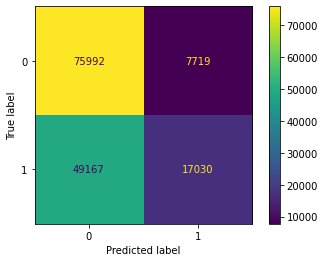

In [76]:
from sklearn.metrics import plot_confusion_matrix

y_pred = nbg_rand_search.predict(X_test)


print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_pred)

plot_confusion_matrix(model, X_test, y_test)

Vale chamar atenção ao fato de que, apesar do score do roc-auc não ser tão distante de outros modelos, o f1-score para covid_res = 1 é bem baixo. Além disso, vemos na matriz de confusão que a quantidade de falsos negativos é bem alta. Levando em consideração o contexto de COVID-19, isso é bem ruim, pois as pessoas contaminadas podem passar a doença a outras pessoas.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=51a49710-5991-4d9e-8d88-f90d59cca546' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>